<center><h1>PEGASUS MODEL</h1>
____________________________________________________</center>

## SET-UP


In [1]:
# ------------------------- # 
#        SET - UP           # 
# ------------------------- # 

# ---- Requirements ----- # 

!pip install datasets
!pip install sentencepiece
!pip install transformers
!pip install rouge_score

import sys
from google.colab import drive
import pandas as pd
import numpy as np
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers.optimization import Adafactor, AdafactorSchedule
import torch
import huggingface_hub
from datasets import load_dataset, Dataset, load_metric
import nltk
nltk.download("punkt")
import gc
from torch import nn 

# ----- Check if GPU is connected ----- # 
gpu_info = !nvidia-smi -L
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU")
else:
    print(gpu_info)

# ----- Mounting Google Drive ----- # 

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/CIS6930_final')

# ----- Importing TweetSum processing module ----- #
from tweet_sum_processor import TweetSumProcessor

# ----- Torch Device ----- #
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ----------------------------------------------------------------------



     |████████████████████████████████| 298 kB 5.3 MB/s 
     |████████████████████████████████| 61 kB 224 kB/s 
     |████████████████████████████████| 1.1 MB 29.4 MB/s 
     |████████████████████████████████| 132 kB 29.8 MB/s 
     |████████████████████████████████| 243 kB 28.4 MB/s 
     |████████████████████████████████| 271 kB 47.7 MB/s 
     |████████████████████████████████| 160 kB 45.3 MB/s 
     |████████████████████████████████| 192 kB 43.7 MB/s 
     |████████████████████████████████| 1.2 MB 5.5 MB/s 
     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 32.8 MB/s 
     |████████████████████████████████| 3.3 MB 32.2 MB/s 
     |████████████████████████████████| 596 kB 40.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.z

# READING IN THE DATA

In [2]:
# ----- Reading in the Dataset
raw_datasets = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/CIS6930_final/tweetsum_train.csv',
                                          'valid': '/content/drive/MyDrive/CIS6930_final/tweetsum_valid.csv',
                                          'test': '/content/drive/MyDrive/CIS6930_final/tweetsum_test.csv'})

Using custom data configuration default-a2b2b2c6b49c0494


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a2b2b2c6b49c0494/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

# DEFINING THE PRE-TRAINED MODEL AND TOKENIZER

In [3]:
# --- DEFINE MODEL AND TOKENIZER --- #

model_name = 'google/pegasus-large'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)
metric = load_metric("rouge")

def freeze_params(model: nn.Module):
    """Set requires_grad=False for each of model.parameters()"""
    for par in model.parameters():
        par.requires_grad = False

def freeze_embeds(model):
    """Freeze token embeddings and positional embeddings for BART and PEGASUS, just token embeddings for t5."""
    model_type = model.config.model_type
    if model_type == "t5":
        freeze_params(model.shared)
        for d in [model.encoder, model.decoder]:
            freeze_params(d.embed_tokens)
    else:
        freeze_params(model.model.shared)
        for d in [model.model.encoder, model.model.decoder]:
            freeze_params(d.embed_positions)
            freeze_params(d.embed_tokens)

freeze_embeds(model)

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

## Tokenizing the Datasets

In [4]:
# --- TOKENIZE THE INPUTS AND SUMMARIES --- #

max_input_length = 512
max_target_length = 128

def preprocess_function(examples):
    model_inputs = tokenizer(examples["inputs"], max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summaries"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

## ARGUMENTS 
Defining the batch size, optimizer, learning rate scheduler, and arguments to the trainer object. The batch size is constrained to 1 due to limited GPU memory - unfortunately, any more than 1 and I receive an OOM error. Parameters such as batch size are kept constant between the models. The only ones that are changed are the optimizer and initial learning rate, which are set to the recommendations for each model. 

In [5]:


batch_size = 1
args = Seq2SeqTrainingArguments(
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
    output_dir = '/content/drive/MyDrive/CIS6930_final/results/pegasus', 
    logging_dir = '/content/drive/MyDrive/CIS6930_final/logs/pegasus'
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None)
lr_scheduler = AdafactorSchedule(optimizer)

def compute_metrics(eval_pred):
  '''
  Function to compute the ROUGE scores inside the training loop.
  '''
  predictions, labels = eval_pred
  decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
  decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
  result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  result["gen_len"] = np.mean(prediction_lens)
  
  return {k: round(v, 4) for k, v in result.items()}

# FINE-TUNING THE MODEL

In [6]:

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    optimizers=(optimizer, lr_scheduler),
    compute_metrics=compute_metrics
)

trainer.train()

Using amp fp16 backend
The following columns in the training set  don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summaries, inputs.
***** Running training *****
  Num examples = 869
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 2607


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.618600,2.061010,42.437200,19.581000,36.776200,39.570200,37.092600
2,1.759500,2.082660,43.727400,20.423900,37.418600,40.674300,38.120400
3,1.593600,2.255910,45.745800,21.165100,38.201700,42.427300,37.592600


Saving model checkpoint to /content/drive/MyDrive/CIS6930_final/results/pegasus/checkpoint-500
Configuration saved in /content/drive/MyDrive/CIS6930_final/results/pegasus/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/CIS6930_final/results/pegasus/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/CIS6930_final/results/pegasus/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/CIS6930_final/results/pegasus/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summaries, inputs.
***** Running Evaluation *****
  Num examples = 108
  Batch size = 1
Saving model checkpoint to /content/drive/MyDrive/CIS6930_final/results/pegasus/checkpoint-1000
Configuration saved in /content/drive/MyDrive/CIS6930_final/results/pegasus/checkpoint-1000/config.json
Model weights 

TrainOutput(global_step=2607, training_loss=1.8906372386374874, metrics={'train_runtime': 5146.5092, 'train_samples_per_second': 0.507, 'train_steps_per_second': 0.507, 'total_flos': 2302575815983104.0, 'train_loss': 1.8906372386374874, 'epoch': 3.0})

# TESTING

In [7]:
# --------------------- # 
#    TEST EVALUATION    #
# --------------------- #

out = trainer.predict(tokenized_datasets["test"])

generated_summaries = []
for i in range(0, 110): 
  generated_summaries.append(tokenizer.decode(out[0][i], skip_special_tokens =  True))
ground_truth = tokenized_datasets["test"]["summaries"]
conversation = tokenized_datasets["test"]["inputs"]


The following columns in the test set  don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summaries, inputs.
***** Running Prediction *****
  Num examples = 110
  Batch size = 1


## ROUGE SCORES 

In [8]:
out.metrics

{'eval_gen_len': 37.0909,
 'eval_loss': 2.3683221340179443,
 'eval_rouge1': 45.083,
 'eval_rouge2': 18.8269,
 'eval_rougeL': 36.3438,
 'eval_rougeLsum': 41.3165,
 'eval_runtime': 332.4477,
 'eval_samples_per_second': 0.331,
 'eval_steps_per_second': 0.331}

## BART-SCORE

In [9]:
!pip install bert_score
from bert_score import score
P, R, F1 = score(generated_summaries, ground_truth, lang="en", verbose=True)

     |████████████████████████████████| 59 kB 3.3 MB/s 


Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/roberta-large/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp_bpj00wl


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
creating metadata file for /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
loading configuration file https://huggingface.co/roberta-large/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_r

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/roberta-large/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpyrj4y117


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
https://huggingface.co/roberta-large/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp7uz_xsbv


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/e16a2590deb9e6d73711d6e05bf27d832fa8c1162d807222e043ca650a556964.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
creating metadata file for /root/.cache/huggingface/transformers/e16a2590deb9e6d73711d6e05bf27d832fa8c1162d807222e043ca650a556964.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-large/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/7c1ba2435b05451bc3b4da073c8dec9630b22024a65f6c41053caccf2880eb8f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-large/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/20b5a00a80e27ae9accbe25672aba42ad2d4d4cb2c4b9359b50ca8e34e107d6d.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/robe

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

storing https://huggingface.co/roberta-large/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
creating metadata file for /root/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
loading weights file https://huggingface.co/roberta-large/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/8e36ec2f5052bec1e79e139b84c2c3089cb647694ba0f4f634fec7b8258f7c89.c43841d8c5cd23c435408295164cda9525270aa42cd0cc9200911570c0342352
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are ini

calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 3.50 seconds, 31.42 sentences/sec


### SCORES

In [10]:
print(f"System level F1 score: {F1.mean():.3f}")
print(f"System level precision score: {P.mean():.3f}")
print(f"System level recall score: {R.mean():.3f}")

System level F1 score: 0.888
System level precision score: 0.887
System level recall score: 0.888


### VISUALIZATIONS

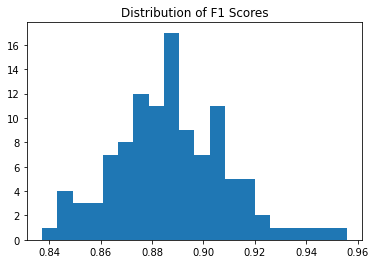

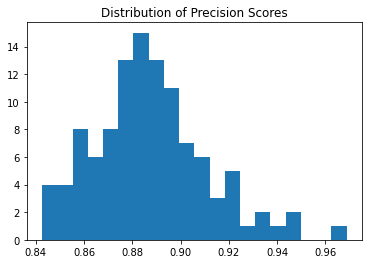

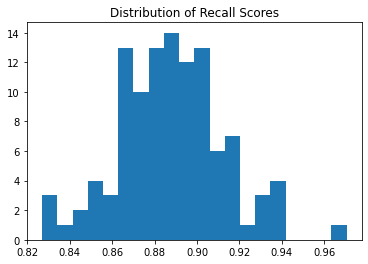

In [11]:
import matplotlib.pyplot as plt
plt.hist(F1, bins=20)
plt.title("Distribution of F1 Scores")
plt.show()

plt.hist(P, bins=20)
plt.title("Distribution of Precision Scores")
plt.show()

plt.hist(R, bins=20)
plt.title("Distribution of Recall Scores")
plt.show()

In [ ]:

drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)
sys.path.append('/content/drive/MyDrive/CIS6930_final')
pegasus_summaries = pd.DataFrame({"candidate": generated_summaries, "reference": ground_truth, "conversation": conversation})
print(pegasus_summaries)
pegasus_summaries.to_csv('pegasus_test_summaries2.csv') 


In [37]:
from google.colab import files
files.download("pegasus_test_summaries2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>